### **Final Exam**
### **Data Mining, Machine Learning and Deep Learning**

**Authors (Student Numbers):** 91849 (Student 1), 111212 (Student 2) & 110599 (Student 3)

**Course Professor:** Raghava Rao Mukkamala

**Submission date:** 11 June - 2020

**Individualization:** Student 1, Student 2 & Student 3 have collaborated equally on the programming part of the assignment



### **Data and library import**

In [31]:
#Mounting google drive(Will only function if the file is shared with your google account)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#Ignoring warnings as they have been inspected, and concluded that they dont have impact.
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

### **Importing Libraries**

In [0]:
!pip install -q confusion_matrix

import pandas as pd

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline

import matplotlib.pyplot as plt

import numpy as np

import seaborn as sns 

import sklearn.metrics
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, homogeneity_score, silhouette_score
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm

### **Defining Functions**

In [0]:
#Data Prep/plotting functions:
def data_prep(df: pd.DataFrame) -> (np.ndarray, np.ndarray):
    X = df.iloc[:, 2:30].values
    y = df.Class.values
    return X, y

def plot_data(X, y, label='Classes'): 
    #Colors for color blindness  
    colors = ['#1E88E5', '#D81B60'] 
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

def model_performance(X_train: np.ndarray, y_train: np.ndarray,
                      X_test: np.ndarray, y_test: np.ndarray, model):
    """
    model: sklearn model (e.g. RandomForestClassifier)
    """
    # Fit your training model to your training set
    model.fit(X_train, y_train)

    # Obtain the predicted values and probabilities from the model 
    predicted = model.predict(X_test)
    
    try:
        probs = model.predict_proba(X_test)
        print('ROC Score:')
        print(roc_auc_score(y_test, probs[:,1]))
    except AttributeError:
        pass

    # Print the ROC curve, classification report and confusion matrix
    print('\nClassification Report:')
    print(classification_report(y_test, predicted))
    print('\nConfusion Matrix:')
    print(confusion_matrix(y_test, predicted))

### **Data inspection**

In [35]:
#Import of data from google drive:
df = pd.read_csv("drive/My Drive/creditcard.csv")

#df.head used to insure that we get the expected columns
df.head()

#df.info() to get information about the dataset
df.info

<bound method DataFrame.info of             Time         V1         V2  ...       V28  Amount  Class
0            0.0  -1.359807  -0.072781  ... -0.021053  149.62      0
1            0.0   1.191857   0.266151  ...  0.014724    2.69      0
2            1.0  -1.358354  -1.340163  ... -0.059752  378.66      0
3            1.0  -0.966272  -0.185226  ...  0.061458  123.50      0
4            2.0  -1.158233   0.877737  ...  0.215153   69.99      0
...          ...        ...        ...  ...       ...     ...    ...
284802  172786.0 -11.881118  10.071785  ...  0.823731    0.77      0
284803  172787.0  -0.732789  -0.055080  ... -0.053527   24.79      0
284804  172788.0   1.919565  -0.301254  ... -0.026561   67.88      0
284805  172788.0  -0.240440   0.530483  ...  0.104533   10.00      0
284806  172792.0  -0.533413  -0.189733  ...  0.013649  217.00      0

[284807 rows x 31 columns]>

In [36]:
# Counting the occurences of the two different values in column "Class"
occurences = df['Class'].value_counts()
print(occurences)
# Using the ratio of cases with "1" in column "Class" and multiplying it with 100 to get it in percentage
ratio_cases = occurences/len(df.index)
print("ratio of fraud cases:")
print(ratio_cases[1])

0    284315
1       492
Name: Class, dtype: int64
ratio of fraud cases:
0.001727485630620034


## **Data visualization and handling of unbalanced data (Resampling)**

### **Resampling using SMOTE Tomek Links**

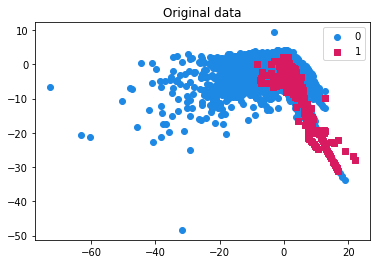

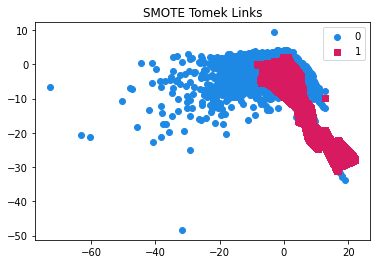

In [37]:
#Using the data_prep function to get numpy arrays, exclude time and define return X and y
X, y = data_prep(df)

#Getting X_smt and y_smt which is the dataset resampled with smoteTomek.
smt = SMOTETomek(ratio='auto', random_state=5)
X_smt, y_smt = smt.fit_sample(X, y)

#Plotting the two and compare them
plot_data(X, y,"Original data")
plot_data(X_smt, y_smt, "SMOTE Tomek Links")

In [38]:
#SMOTE Tomek Links Comparison with orignial data. SMOTE Tomek should make sure 
#that there are equal amounts of fraud and non-fraud cases.
print("Original data:")
print(pd.value_counts(pd.Series(y)))

print("Resampled data using SMOTE Tomek Links:")
print(pd.value_counts(pd.Series(y_smt)))

Original data:
0    284315
1       492
dtype: int64
Resampled data using SMOTE Tomek Links:
1    284315
0    284315
dtype: int64


### **Resampling using ADASYN**

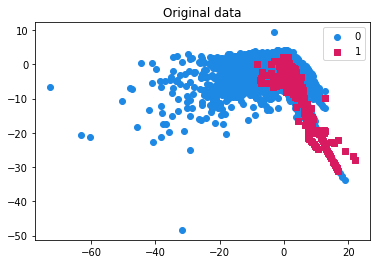

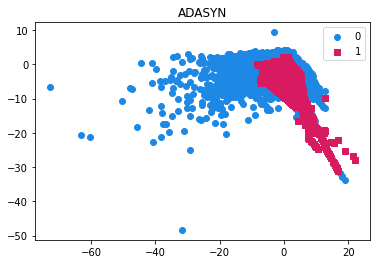

In [39]:
#Resampling with adasyn and getting X_adasyn and y_adasyn
X_adasyn, y_adasyn = ADASYN().fit_sample(X, y)
#Comparing adasyn with orignial data:
plot_data(X, y,"Original data")
plot_data(X_adasyn,y_adasyn,"ADASYN")

### **Logistic Regression Baseline Model**

In [40]:
# Define which resampling methods to be used in pipelines
resampling_smt = SMOTETomek(ratio='auto')
resampling_adasyn = ADASYN(ratio='auto', random_state=5) 

#Create a logistic regression model as logReg
logReg = LogisticRegression()

# Split data X and y, into a training and a test set and fitting the pipeline onto the training data. Split = 75/25.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=5)

#Create Baseline Model without the Resampling
print('\n Logistic Regression without resampling (baseline model')
model_performance(X_train, y_train, X_test, y_test, logReg)


 Logistic Regression without resampling (baseline model
ROC Score:
0.9658374842064128

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71081
           1       0.86      0.67      0.75       121

    accuracy                           1.00     71202
   macro avg       0.93      0.83      0.88     71202
weighted avg       1.00      1.00      1.00     71202


Confusion Matrix:
[[71068    13]
 [   40    81]]


### **Logistic Regression including SMOTE-Tomek Links Resampling**

In [41]:
# Create Pipeline combining resampling (SMOTE Tomek Links) & model (logReg)
smt_logReg = Pipeline([('SMOTE Tomek Links', resampling_smt), ('Logistic Regression', logReg)])

#Testing Model Performance
print('\n Logistic Regression with SMOTETomek resampling')
model_performance(X_train, y_train, X_test, y_test, smt_logReg)


 Logistic Regression with SMOTETomek resampling
ROC Score:
0.9635682188205494

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     71081
           1       0.08      0.89      0.15       121

    accuracy                           0.98     71202
   macro avg       0.54      0.94      0.57     71202
weighted avg       1.00      0.98      0.99     71202


Confusion Matrix:
[[69888  1193]
 [   13   108]]


### **Logistic Regression including ADASYN Resampling**

In [42]:
# Create Pipeline combining resampling (ADASYN) & model (logReg)
adasyn_logReg = Pipeline([('ADASYN', resampling_adasyn), ('Logistic Regression', logReg)])

#Testing Model Performance
print('\n Logistic Regression with ADASYN resampling')
model_performance(X_train, y_train, X_test, y_test, adasyn_logReg)


 Logistic Regression with ADASYN resampling
ROC Score:
0.9631191327412412

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98     71081
           1       0.03      0.92      0.06       121

    accuracy                           0.95     71202
   macro avg       0.52      0.93      0.52     71202
weighted avg       1.00      0.95      0.97     71202


Confusion Matrix:
[[67636  3445]
 [   10   111]]


### **Random Forest Classifier including ADASYN resampling**

In [43]:
#Create a simple Random Forest Classifier
rfc = RandomForestClassifier(random_state = 5)

#Create a Pipeline combining ADASYN resampling and the Random Forest Classifier Model
adasyn_rfc = Pipeline([('ADASYN', resampling_adasyn), ('Random Forest Classifier', rfc)])

#Create a Pipeline combining smt resampling and the Random Forest Classifier Model
smt_rfc = Pipeline([('SMOTETomek Links', resampling_smt), ('Random Forest Classifier', rfc)])

# Testing Model Performance of the Pipeline adasyn_rfc
print('\nADASYN & Random Forest Classifier - Model Performance:')
model_performance(X_train, y_train, X_test, y_test, adasyn_rfc)

# Testing Model Performance of the Pipeline smt_rfc
print('\nSMOTE Tomek Links & Random Forest Classifier - Model Performance:')
model_performance(X_train, y_train, X_test, y_test, smt_rfc)


ADASYN & Random Forest Classifier - Model Performance:
ROC Score:
0.9697448528340559

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71081
           1       0.90      0.84      0.87       121

    accuracy                           1.00     71202
   macro avg       0.95      0.92      0.94     71202
weighted avg       1.00      1.00      1.00     71202


Confusion Matrix:
[[71070    11]
 [   19   102]]

SMOTE Tomek Links & Random Forest Classifier - Model Performance:
ROC Score:
0.9773879781662197

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71081
           1       0.90      0.85      0.87       121

    accuracy                           1.00     71202
   macro avg       0.95      0.93      0.94     71202
weighted avg       1.00      1.00      1.00     71202


Confusion Matrix:
[[71069    12]
 [   18   103]]


### **Performing GridSearchCV in order to obtain the Optimal Parameters for the Random Forest Classifier Model - Optimized for Recall**



In [44]:
# Create a parameter grid 
param_grid = {"Random Forest Classifier__max_depth": [4,8,10,12],
              "Random Forest Classifier__max_features": ["auto", "log2"],
              "Random Forest Classifier__n_estimators": [1,30],
              "Random Forest Classifier__criterion": ['gini','entropy']
              }

#Renaming the Pipeline which the model is based upon 
model = adasyn_rfc
model1 = smt_rfc

#Perform GridSearchCV to get the best parameter of adasyn_rfc
##CV_model = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring="recall", n_jobs=-1)
##CV_model.fit(X_train,y_train)
##CV_model.best_params_

"""
Optimal parameters (adasyn_rfc):
{'Random Forest Classifier__criterion': 'entropy',
 'Random Forest Classifier__max_depth': 4, 
 'Random Forest Classifier__max_features': 'auto', 
 'Random Forest Classifier__n_estimators': 30}
"""

#Perform GridSearchCV to get the best parameter of smt_rfc
##CV_model1 = GridSearchCV(estimator=model1, param_grid=param_grid, cv=5, scoring="recall", n_jobs=-1)
##CV_model1.fit(X_train,y_train)
##CV_model1.best_params_

"""
Optimal parameters (smt_rfc)
 {'Random Forest Classifier__criterion': 'entropy',
 'Random Forest Classifier__max_depth': 8,
 'Random Forest Classifier__max_features': 'auto',
 'Random Forest Classifier__n_estimators': 1}
"""

"\nOptimal parameters (smt_rfc)\n {'Random Forest Classifier__criterion': 'entropy',\n 'Random Forest Classifier__max_depth': 8,\n 'Random Forest Classifier__max_features': 'auto',\n 'Random Forest Classifier__n_estimators': 1}\n"

### **Optimized Random Forest Classifier including ADASYN resampling**

In [45]:
# Input the optimal parameters in the Random Forest Model
rfc = RandomForestClassifier(criterion='entropy',
                               max_depth=4,
                               max_features='auto',
                               n_estimators=30,
                               n_jobs=-1,
                               random_state=5)

# Creating a Pipeline based on ADASYN resampling and the Optimized Random Forest Classifier
adasyn_rfc = Pipeline([('ADASYN', resampling_adasyn), ('Random Forest Classifier', rfc)])

# Creating a Pipeline based on SMOTE Tomek-Links resampling and the Optimized Random Forest Classifier
smt_rfc = Pipeline([('SMOTE Tomek Links', resampling_smt), ('Random Forest Classifier', rfc)])

# Testing the Performance of adasyn_rfc
print('\n"ADASYN & Optimized Random Forest Classifier" Model Performance:')
model_performance(X_train, y_train, X_test, y_test, adasyn_rfc)

# Testing the Performance of smt_rfc
print('\n"SMOTE Tomek-Links & Optimized Random Forest Classifier" Model Performance:')
model_performance(X_train, y_train, X_test, y_test, smt_rfc)


"ADASYN & Optimized Random Forest Classifier" Model Performance:
ROC Score:
0.9767317602162868

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     71081
           1       0.08      0.90      0.15       121

    accuracy                           0.98     71202
   macro avg       0.54      0.94      0.57     71202
weighted avg       1.00      0.98      0.99     71202


Confusion Matrix:
[[69812  1269]
 [   12   109]]

"SMOTE Tomek-Links & Optimized Random Forest Classifier" Model Performance:
ROC Score:
0.9683853864308686

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71081
           1       0.29      0.88      0.44       121

    accuracy                           1.00     71202
   macro avg       0.65      0.94      0.72     71202
weighted avg       1.00      1.00      1.00     71202


Confusion Matrix:
[[70821   260]
 [   14   1

### **Gaussian Naive Bayes including ADASYN resampling**

In [46]:
#Create a Gaussian Naive Bayes model
gnb = GaussianNB()

# Define a pipeline combining ADASYN with the Gaussian Naive Bayes model
adasyn_gnb = Pipeline([('ADASYN', resampling_adasyn), ('Gaussian Naive Bayes', gnb)])

# Define a pipeline combining SMOTE Tomek-Links with the Gaussian Naive Bayes model
smt_gnb = Pipeline([('SMOTE Tomek-Links', resampling_smt), ('Gaussian Naive Bayes', gnb)])

print('\n Gaussian Naive Bayes with ADASYN resampling')
model_performance(X_train, y_train, X_test, y_test, adasyn_gnb)

print('\n Gaussian Naive Bayes with SMOTE Tomek-Links resampling')
model_performance(X_train, y_train, X_test, y_test, smt_gnb)


 Gaussian Naive Bayes with ADASYN resampling
ROC Score:
0.9717279820798086

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     71081
           1       0.04      0.89      0.08       121

    accuracy                           0.96     71202
   macro avg       0.52      0.93      0.53     71202
weighted avg       1.00      0.96      0.98     71202


Confusion Matrix:
[[68522  2559]
 [   13   108]]

 Gaussian Naive Bayes with SMOTE Tomek-Links resampling
ROC Score:
0.9689218480929858

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     71081
           1       0.06      0.87      0.11       121

    accuracy                           0.98     71202
   macro avg       0.53      0.92      0.55     71202
weighted avg       1.00      0.98      0.99     71202


Confusion Matrix:
[[69423  1658]
 [   16   105]]


In [47]:
"""
 Testing Model Performance of each of models
print('\nADASYN & Optimized Random Forest Classifier - Model Performance:')
model_performance(X_train, y_train, X_test, y_test, adasyn_rfc)
print('\nADASYN & Logistic Regression - Model Performance:')
model_performance(X_train, y_train, X_test, y_test, adasyn_logReg)
print('\nADASYN & Gaussian Naive Bayes - Model Performance:')
model_performance(X_train, y_train, X_test, y_test, adasyn_gnb)
"""

"\n Testing Model Performance of each of models\nprint('\nADASYN & Optimized Random Forest Classifier - Model Performance:')\nmodel_performance(X_train, y_train, X_test, y_test, adasyn_rfc)\nprint('\nADASYN & Logistic Regression - Model Performance:')\nmodel_performance(X_train, y_train, X_test, y_test, adasyn_logReg)\nprint('\nADASYN & Gaussian Naive Bayes - Model Performance:')\nmodel_performance(X_train, y_train, X_test, y_test, adasyn_gnb)\n"

### **Creating Ensemble Models**

In [0]:
# Combine models into ensemble models and testing with Hard/Soft Voting and weights
ensemble_model_adasyn = VotingClassifier(estimators=[('rfc', adasyn_rfc), ('logReg', adasyn_logReg), ('gnb', adasyn_gnb)], voting='hard')
ensemble_model1_adasyn = VotingClassifier(estimators=[('rfc', adasyn_rfc), ('logReg', adasyn_logReg), ('gnb', adasyn_gnb)], voting='soft')
ensemble_model2_adasyn = VotingClassifier(estimators=[('rfc', adasyn_rfc), ('logReg', adasyn_logReg), ('gnb', adasyn_gnb)], voting='soft', weights=[1,3,1])
ensemble_model3_adasyn = VotingClassifier(estimators=[('rfc', adasyn_rfc), ('logReg', adasyn_logReg), ('gnb', adasyn_gnb)], voting='soft', weights=[2,1,1])
ensemble_model4_adasyn = VotingClassifier(estimators=[('rfc', adasyn_rfc), ('logReg', adasyn_logReg), ('gnb', adasyn_gnb)], voting='soft', weights=[3,1,1])

# Combine models into ensemble models and testing with Hard/Soft Voting and weights
ensemble_model_smt = VotingClassifier(estimators=[('rfc', smt_rfc), ('logReg', smt_logReg), ('gnb', smt_gnb)], voting='hard')
ensemble_model1_smt = VotingClassifier(estimators=[('rfc', smt_rfc), ('logReg', smt_logReg), ('gnb', smt_gnb)], voting='soft')
ensemble_model2_smt = VotingClassifier(estimators=[('rfc', smt_rfc), ('logReg', smt_logReg), ('gnb', smt_gnb)], voting='soft', weights=[1,3,1])
ensemble_model3_smt = VotingClassifier(estimators=[('rfc', smt_rfc), ('logReg', smt_logReg), ('gnb', smt_gnb)], voting='soft', weights=[2,1,1])
ensemble_model4_smt = VotingClassifier(estimators=[('rfc', smt_rfc), ('logReg', smt_logReg), ('gnb', smt_gnb)], voting='soft', weights=[3,1,1])

### **Ensemble Model Performance (Hard Voting):**

In [49]:
model_performance(X_train, y_train, X_test, y_test, ensemble_model_adasyn)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     71081
           1       0.07      0.90      0.13       121

    accuracy                           0.98     71202
   macro avg       0.53      0.94      0.56     71202
weighted avg       1.00      0.98      0.99     71202


Confusion Matrix:
[[69620  1461]
 [   12   109]]


### **Ensemble Model Performance (Soft Voting)**

In [50]:
model_performance(X_train, y_train, X_test, y_test, ensemble_model1_adasyn)

ROC Score:
0.9751222589616945

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     71081
           1       0.08      0.91      0.14       121

    accuracy                           0.98     71202
   macro avg       0.54      0.95      0.57     71202
weighted avg       1.00      0.98      0.99     71202


Confusion Matrix:
[[69788  1293]
 [   11   110]]


### **Ensemble Model Performance (Soft Voting, Weighted) 1,3,1)**

In [51]:
model_performance(X_train, y_train, X_test, y_test, ensemble_model2_adasyn)

ROC Score:
0.9728624694374396

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     71081
           1       0.05      0.91      0.10       121

    accuracy                           0.97     71202
   macro avg       0.53      0.94      0.54     71202
weighted avg       1.00      0.97      0.98     71202


Confusion Matrix:
[[69099  1982]
 [   11   110]]


### **Ensemble Model Performance (Soft Voting, Weighted 2,1,1)**

In [52]:
model_performance(X_train, y_train, X_test, y_test, ensemble_model3_adasyn)

ROC Score:
0.9765166639711814

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     71081
           1       0.08      0.91      0.15       121

    accuracy                           0.98     71202
   macro avg       0.54      0.95      0.57     71202
weighted avg       1.00      0.98      0.99     71202


Confusion Matrix:
[[69877  1204]
 [   11   110]]


### **Ensemble Model Performance (Soft Voting, Weighted 3,1,1)**

In [53]:
model_performance(X_train, y_train, X_test, y_test, ensemble_model4_adasyn)

ROC Score:
0.9769791790322785

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     71081
           1       0.09      0.90      0.16       121

    accuracy                           0.98     71202
   macro avg       0.54      0.94      0.58     71202
weighted avg       1.00      0.98      0.99     71202


Confusion Matrix:
[[69942  1139]
 [   12   109]]


### **Testing Ensemble Model Performance based on SMOTE + Tomek Links Resampling**

In [54]:
#Create a Pipeline combining ADASYN resampling and the Random Forest Classifier Model
smt_rfc = Pipeline([('SMOTE + Tomek Links', resampling_smt), ('Random Forest Classifier', rfc)])

# Combine models into ensemble models and testing with Hard/Soft Voting and weights
ensemble_model_smt = VotingClassifier(estimators=[('rfc', smt_rfc), ('logReg', smt_logReg), ('gnb', smt_gnb)], voting='hard')
ensemble_model1_smt = VotingClassifier(estimators=[('rfc', smt_rfc), ('logReg', smt_logReg), ('gnb', smt_gnb)], voting='soft')
ensemble_model2_smt = VotingClassifier(estimators=[('rfc', smt_rfc), ('logReg', smt_logReg), ('gnb', smt_gnb)], voting='soft', weights=[1,3,1])
ensemble_model3_smt = VotingClassifier(estimators=[('rfc', smt_rfc), ('logReg', smt_logReg), ('gnb', smt_gnb)], voting='soft', weights=[2,1,1])
ensemble_model4_smt = VotingClassifier(estimators=[('rfc', smt_rfc), ('logReg', smt_logReg), ('gnb', smt_gnb)], voting='soft', weights=[3,1,1])


model_performance(X_train, y_train, X_test, y_test, ensemble_model_smt)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     71081
           1       0.22      0.88      0.35       121

    accuracy                           0.99     71202
   macro avg       0.61      0.94      0.67     71202
weighted avg       1.00      0.99      1.00     71202


Confusion Matrix:
[[70702   379]
 [   15   106]]


In [55]:
model_performance(X_train, y_train, X_test, y_test, ensemble_model1_smt)

ROC Score:
0.9694723782122154

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     71081
           1       0.20      0.88      0.32       121

    accuracy                           0.99     71202
   macro avg       0.60      0.93      0.66     71202
weighted avg       1.00      0.99      1.00     71202


Confusion Matrix:
[[70645   436]
 [   15   106]]


In [56]:
model_performance(X_train, y_train, X_test, y_test, ensemble_model2_smt)

ROC Score:
0.9704201969095669

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     71081
           1       0.14      0.89      0.24       121

    accuracy                           0.99     71202
   macro avg       0.57      0.94      0.62     71202
weighted avg       1.00      0.99      0.99     71202


Confusion Matrix:
[[70392   689]
 [   13   108]]


In [57]:
model_performance(X_train, y_train, X_test, y_test, ensemble_model3_smt)

ROC Score:
0.9709840978764652

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71081
           1       0.23      0.88      0.36       121

    accuracy                           0.99     71202
   macro avg       0.61      0.94      0.68     71202
weighted avg       1.00      0.99      1.00     71202


Confusion Matrix:
[[70726   355]
 [   15   106]]


In [58]:
model_performance(X_train, y_train, X_test, y_test, ensemble_model4_smt)

ROC Score:
0.9688459249318755

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71081
           1       0.24      0.88      0.38       121

    accuracy                           1.00     71202
   macro avg       0.62      0.94      0.69     71202
weighted avg       1.00      1.00      1.00     71202


Confusion Matrix:
[[70748   333]
 [   15   106]]
